In [1]:
using Compat, Distributions, Plots, LaTeXStrings, PyCall, Plotly

HTML{String}("    <script id=\"webio-setup-10599838882605587094\">\n    // Immediately-invoked-function-expression to avoid global variables.\n    (function() {\n        var warning_div = document.getElementById(\"webio-warning-14107134065396156888\");\n        var hide = function () {\n            var script = document.getElementById(\"webio-setup-10599838882605587094\");\n            var parent = script && script.parentElement;\n            var grandparent = parent && parent.parentElement;\n            if (grandparent) {\n                grandparent.style.display = \"none\";\n            }\n            warning_div.style.display = \"none\";\n        };\n        if (window.require && require.defined) {\n            // Jupyter notebook.\n            if (require.defined(\"nbextensions/webio/main\")\n                    || require.defined(\"/assetserver/9d02ba3de810d28758c40d4d1881f07994467157-dist/main.js\")) {\n                // Extension already loaded.\n                hide();\n                return;\n            }\n            console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n            require([\"/assetserver/9d02ba3de810d28758c40d4d1881f07994467157-dist/main.js\"], function (webIOModule) {\n                webIOModule.load_ipython_extension();\n            });\n            warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n        } else if (window.location.pathname.includes(\"/lab\")) {\n            // Guessing JupyterLab\n            warning_div.innerHTML = \"WebIO does not support JupyterLab yet.\";\n        }\n    })();\n    </script>\n    <div\n        id=\"webio-warning-14107134065396156888\"\n        class=\"output_text output_stderr\"\n        style=\"padding: 1em; font-weight: bold;\"\n    >\n        Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n        <!-- TODO: link to installation docs. -->\n    </div>\n")

┌ Warning: IJulia doesn't have register_mime; WebIO may not work as expected. Please upgrade to IJulia v1.13.0 or greater.
└ @ WebIO C:\Users\adwol\.julia\packages\WebIO\NYISm\src\providers\ijulia.jl:38


In [2]:
function ols(a,b)
    k = length(b[:,1])
    beta = inv(b'*b)*(b'*a)
    e = a-b*beta
    varcov = (e'*e/k)*inv(b'*b)
    t = beta[1]/sqrt(varcov[1,1])
    [beta[1] t]
end

ols (generic function with 1 method)

In this part of the simulation, we show that it is important to include lagged first differences of the dependent variable $y_t$ into the regression when the error term has $MA(q)$ structure to it. If those lags are not included, the quick and seamless convergence that we observed in the simple ARCH case will not be repeated here. Observe the simulations below.

In [3]:
nrep = 10000
d = Normal()
q = 100
T = 1000

1000

In [4]:
beta_hat = zeros(1,nrep)
t_stat = zeros(1,nrep)
for n = 1:nrep
    y = zeros(1,T)
    coef = ones(q)
    for j=1:q
        coef[j] = 1/j
    end
    epsilon = randn(1,T+q)
    for t = 1:T-1
        y[t+1] = y[t]
        for j = 1:q
            y[t+1] = y[t+1] + coef[j]*epsilon[t+q+2-j]
        end
    end
    p = 0
    x = zeros(T-p-1,p+1)
    x[:,1] = y[p+1:T-1]
    for i = 2:p+1
       x[:,i] = y[i:T-p-2+i]-y[i-1:T-p-3+i]
    end
    z = y[p+2:T]-y[p+1:T-1]
    ols(z,x)
    beta_hat[n] = ols(z,x)[1]
    t_stat[n] = ols(z,x)[2]
end

Above is a similar data generation process to the one we used in the first part of the code, with the exception that now the error term is generated using a 100-long MA process of white noises. For simplicity, we assume that the $j$-th coefficient in this process is equal to $\frac{1}{j}$, making it accord with the assumptions of the studied paper.

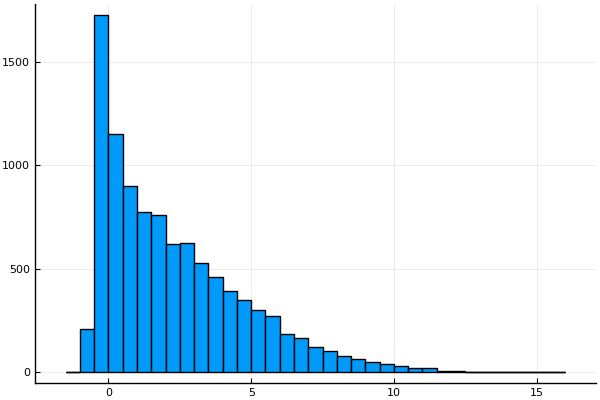

In [5]:
Plots.pyplot()
Plots.histogram(t_stat',
    bins = 50,        
    layout=1,
            legend=:none,
            titlefont=Plots.font(9))

In [6]:
using StatsBase

tdraws = t_stat[1:nrep]
f = ecdf(tdraws)

(::ef) (generic function with 2 methods)

Here we will quickly generate the supposed asymptotic distribution of our $t$-statistic.

In [7]:
G = 1000
u = 0:1/G:1
N = 1000
KLbasis = zeros(N,G+1)
for k = 1:N
   KLbasis[k,:] = (sqrt(2)/((k-.5)*pi))*sin.((k-.5)*pi*u) 
end

draws = zeros(nrep)
for i = 1:nrep
    B = randn(1,N)*KLbasis
    B2 = B.^2
    d = (0.5*(B[1,G+1]^2-1))./sqrt.(sum(B2)/G)
    draws[i] = d[1,1]
end

g = ecdf(draws)

(::ef) (generic function with 2 methods)

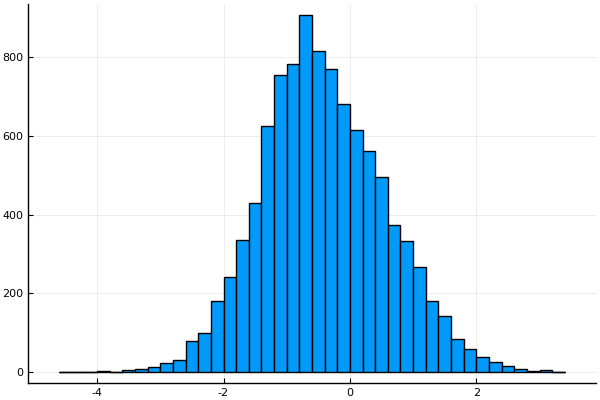

In [8]:
Plots.histogram(draws,
    bins = 50,        
    layout=1,
            legend=:none,
            titlefont=Plots.font(9))

Above is the histogram of the supposed asymptotic distribution. It is even visually drastically different from the simulated distribution of $t$-statistics that we obtained a little higher above. Let us run the Kolmogorov-Smirnov nonparametric test of whether the two obtained distributions are the same, since it will be useful to compare it numerically to subsequent simulations:

In [9]:
diff = 0
set = -20:1/10:20
for i=1:length(set)
    if abs(f(set[i])-g(set[i]))>diff
        diff = abs(f(set[i])-g(set[i]))
    end
end
diff

0.5189

As we see, the two distributions are significantly different from each other, with the highest difference between cdfs being at least $0.5$, even though the sample size is pretty big ($T=1000$). The reason for that lies in us not including any first differences of the dependent variable into the regression, making the resulting coefficients more biased (seemingly towards the positive end). 

Let us now try to include several (say, $30$) lagged differences of the dependent variable into the regression, and then compare the resulting distributions again.

In [10]:
beta_hat = zeros(1,nrep)
t_stat = zeros(1,nrep)
for n = 1:nrep
    y = zeros(1,T)
    coef = ones(q)
    for j=1:q
        coef[j] = 1/j
    end
    epsilon = randn(1,T+q)
    for t = 1:T-1
        y[t+1] = y[t]
        for j = 1:q
            y[t+1] = y[t+1] + coef[j]*epsilon[t+q+2-j]
        end
    end
    p = 30
    x = zeros(T-p-1,p+1)
    x[:,1] = y[p+1:T-1]
    for i = 2:p+1
       x[:,i] = y[i:T-p-2+i]-y[i-1:T-p-3+i]
    end
    z = y[p+2:T]-y[p+1:T-1]
    ols(z,x)
    beta_hat[n] = ols(z,x)[1]
    t_stat[n] = ols(z,x)[2]
end

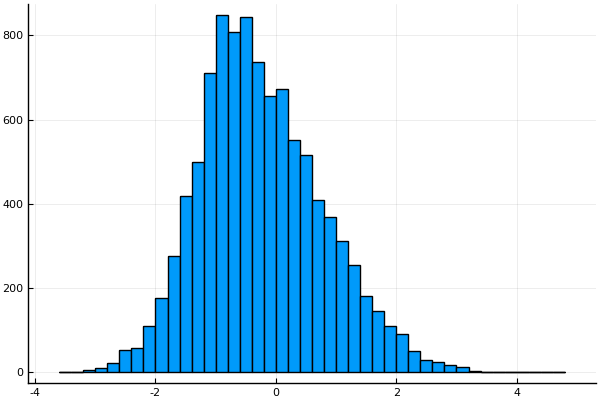

In [11]:
Plots.pyplot()
Plots.histogram(t_stat',
    bins = 50,        
    layout=1,
            legend=:none,
            titlefont=Plots.font(9))

In [12]:
tdraws = t_stat[1:nrep]
f = ecdf(tdraws)

diff = 0
set = -20:1/10:20
for i=1:length(set)
    if abs(f(set[i])-g(set[i]))>diff
        diff = abs(f(set[i])-g(set[i]))
    end
end
diff

0.05480000000000007

The discrepancy between the two distributions has been substantially reduced. If we increase the number of lags we include, the convergence will become clear. Here are the same simulations with $70$ and $100$ lags included.

In [20]:
beta_hat = zeros(1,nrep)
t_stat = zeros(1,nrep)
for n = 1:nrep
    y = zeros(1,T)
    coef = ones(q)
    for j=1:q
        coef[j] = 1/j
    end
    epsilon = randn(1,T+q)
    for t = 1:T-1
        y[t+1] = y[t]
        for j = 1:q
            y[t+1] = y[t+1] + coef[j]*epsilon[t+q+2-j]
        end
    end
    p = 70
    x = zeros(T-p-1,p+1)
    x[:,1] = y[p+1:T-1]
    for i = 2:p+1
       x[:,i] = y[i:T-p-2+i]-y[i-1:T-p-3+i]
    end
    z = y[p+2:T]-y[p+1:T-1]
    ols(z,x)
    beta_hat[n] = ols(z,x)[1]
    t_stat[n] = ols(z,x)[2]
end

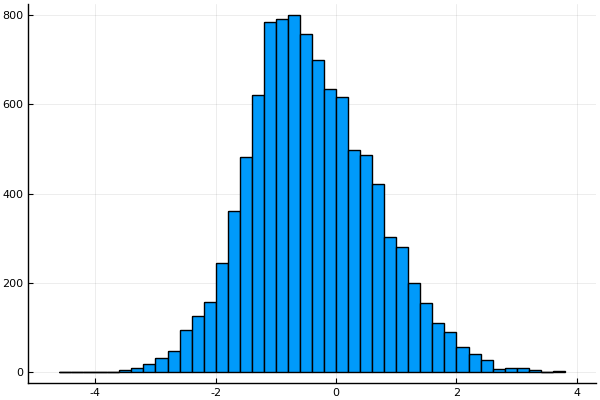

In [21]:
Plots.pyplot()
Plots.histogram(t_stat',
    bins = 50,        
    layout=1,
            legend=:none,
            titlefont=Plots.font(9))

In [22]:
tdraws = t_stat[1:nrep]
f = ecdf(tdraws)

diff = 0
set = -20:1/10:20
for i=1:length(set)
    if abs(f(set[i])-g(set[i]))>diff
        diff = abs(f(set[i])-g(set[i]))
    end
end
diff

0.022699999999999998

In [23]:
beta_hat = zeros(1,nrep)
t_stat = zeros(1,nrep)
for n = 1:nrep
    y = zeros(1,T)
    coef = ones(q)
    for j=1:q
        coef[j] = 1/j
    end
    epsilon = randn(1,T+q)
    for t = 1:T-1
        y[t+1] = y[t]
        for j = 1:q
            y[t+1] = y[t+1] + coef[j]*epsilon[t+q+2-j]
        end
    end
    p = 100
    x = zeros(T-p-1,p+1)
    x[:,1] = y[p+1:T-1]
    for i = 2:p+1
       x[:,i] = y[i:T-p-2+i]-y[i-1:T-p-3+i]
    end
    z = y[p+2:T]-y[p+1:T-1]
    ols(z,x)
    beta_hat[n] = ols(z,x)[1]
    t_stat[n] = ols(z,x)[2]
end

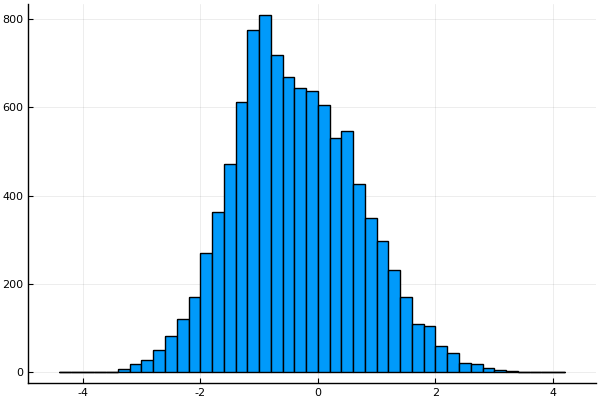

In [24]:
Plots.pyplot()
Plots.histogram(t_stat',
    bins = 50,        
    layout=1,
            legend=:none,
            titlefont=Plots.font(9))

In [25]:
tdraws = t_stat[1:nrep]
f = ecdf(tdraws)

diff = 0
set = -20:1/10:20
for i=1:length(set)
    if abs(f(set[i])-g(set[i]))>diff
        diff = abs(f(set[i])-g(set[i]))
    end
end
diff

0.03610000000000002